# Suction and capillary fringe thickness (p 20)

How much capillary rise can we expect depending on pore radius?

(see exercise 14 on page 27 of the syllabus.


T.N. Olsthoorn (2018-12-30)

In [1]:
import nbconvert

Let a straw with radius $r$ represent the porous medium with the same effective pore size. Then the equlibrium at elevation where presssure is equal to atmospheric pressure, i.e. bij definition, this is the water table, we have

$$ \rho g h \pi r^2 = 2 \pi r \gamma \cos{\alpha} $$

and so

$$ h = \frac {2 \gamma \cos \alpha} {\rho g r} $$

If the direction of the cohesion is virtually in the direction of the water surface in the straw, meaning its tension equals the surface tension of the water in the straw, $\tau = 75 \times 10^-3 $ N/m.

Assuming that the angle $\gamma$ is quite small, we may say $\cos \alpha \approx 1$, which yields

$$h \approx \frac {2 \gamma} {\rho g r}$$

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
import pdb

rho = 1e3 # kg/m3
g = 9.81 # N/kg
gam = 75e-3 # N/m
r = np.logspace(-5, -3, 31)
h = 2 * gam / (rho * g * r)

attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

def newfig(title="title", xlabel="xlabel", ylabel="ylabel",
           xlim=None, ylim=None, xscale='linear', yscale='linear', size_inches=(12, 8)):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.grid()
    return ax

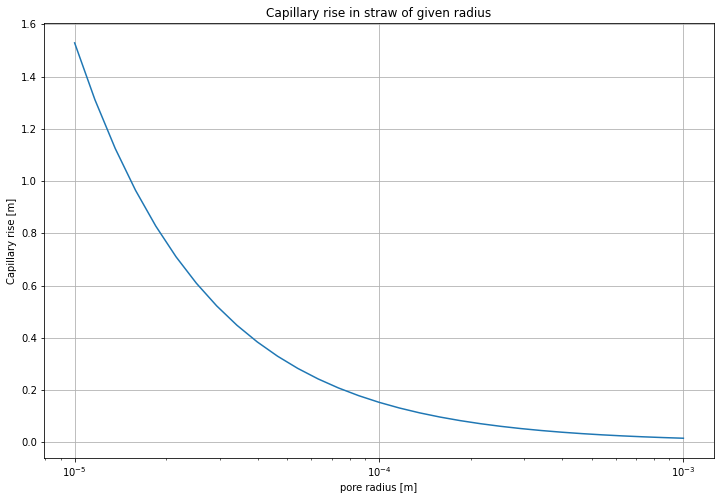

In [23]:
ax = newfig('Capillary rise in straw of given radius', 'pore radius [m]',
           'Capillary rise [m]', xscale='log')
ax.plot(r, h)

Note that the effective grain diameter is about 10 times the effective pore radius. How to derive this, is another matter. It can be one by comparing Poisseuille flow in a tube with a porous medium by using the hydraulic radius instead of pore radius for both.

A sand of a grain diameter of say 0.2 mm will have a conductivity of around 10 m/d and a capillary rise of about 20 cm. This should correspond with a pore radius of 0.02 mm




In [139]:
class Straw:
    """Class defining a single straw."""
    def __init__(self, r, x):
        """Return a straw object with r and position given."""
        self.gam = 75e-3 # N/m
        self.rho = 1000. # [kf/m3]
        self.g = 9.81    # [N/kg]
        self.r = r # [m]
        self.x = x # [m]
        self.bbox = Bbox.null()
        
    @property
    def h(self):
        return 2 * self.gam / (self.rho * self.g * self.r)
        
    @property
    def surface(self):
        """Fluid surface in the straw."""
        angle = np.linspace(-180, 0, 36) * np.pi / 180.
        xy = np.vstack((self.x + self.r * np.cos(angle),
                        self.h + self.r * np.sin(angle))).T
        return xy
                       
    def plot(self, ax=None):
        """Generate a strawpatch and add it to ax."""
        MOVETO = 1
        LINETO = 2
        CLOSE = 90
        xys = np.array([[self.x - self.r, 0]])
        xye = np.array([[self.x + self.r, 0]])
        xy  = np.vstack((xys, self.surface, xye, xys))
        
        codes = np.zeros(xy.shape[0], dtype=int)  + LINETO
        codes[ 0] = MOVETO
        codes[-1] = CLOSE
        
        p = Path(xy, codes=codes)
                               
        ax.add_patch(PathPatch(path=p, fc='lightblue', ec='black'))
        self.bbox.update_from_path(p)
        
    def plotz(self, z=None, ax=None, **kw):
        """Plot the sides of the capilarry.
        
        Paramters
        ---------
        z: float
            height to plot the sides of the sraw
        ax: Axes object
            the axes
        kw: dict
            further parameters passed on to ax.plot()        
        """
        xyL = np.array([[self.x - self.r, 0],
                        [self.x - self.r, z]])
        xyR = np.array([[self.x + self.r, 0],
                        [self.x + self.r, z]])
        line1, = ax.plot(*xyL.T, **kw)
        line2, = ax.plot(*xyR.T, **kw)
        return (line1, line2)

class Straw_collection:
    """Class for collection of straws with random width between r_min and r_max."""
    def __init__(self, r_min, r_max, n=25, sort=False, seed=None):
        
        self.r_min = r_min
        self.r_max = r_max
        np.random.seed(seed)
        self.r = np.random.rand(n) * (r_max - r_min) + r_min
        self.r = np.random.exponential((r_max + r_min) / 2, n) + r_min 
        if sort:
            self.r = np.array(sorted(self.r))
        self.x = np.hstack((0, np.cumsum(2 * self.r)))
        self.x = 0.5 * (self.x[:-1] + self.x[1:])
        self.x -= self.x.mean()        
        self.straws = []
        
        for ri, xi in zip(self.r, self.x):
            self.straws.append(Straw(ri, xi))
            
    def __getitem__(self, k):
        """Return straw[k]."""
        return self.straws[k]

    @property
    def zcap(self):
        return 1.05 * np.array([straw.h for straw in self.straws]).max()
    
    def plot(self, ax=None):
        """Plot all the straws."""        
        for straw in self.straws:
            straw.plot(ax=ax)
            straw.plotz(color='darkgray', lw=0.25, z=self.zcap, ax=ax)
            
        

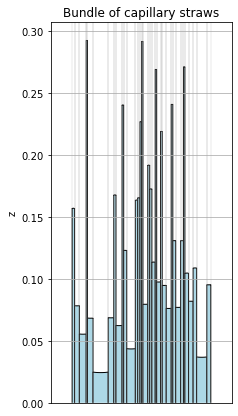

In [148]:
straws = Straw_collection(0.00005, 0.0002, 35, sort=False, seed=1)
rmax = np.array([straw.r for straw in straws]).max()
xlim = straws.x.min() - 3 * rmax, straws.x.max() + 3 * rmax
ylim = (0, np.array([straw.h for straw in straws]).max() * 1.05)

ax = newfig("Bundle of capillary straws", "x", "z", xlim=xlim, ylim=ylim,
           size_inches=(12, 7))


straws.plot(ax=ax)
ax.xaxis.set_visible(False)

#for straw in straws:
#    print(straw.x - straw.r, straw.x + straw.r)
ax.set_aspect(0.1)

In [134]:
attribs(ax)

['acorr',
 'add_artist',
 'add_callback',
 'add_child_axes',
 'add_collection',
 'add_container',
 'add_image',
 'add_line',
 'add_patch',
 'add_table',
 'angle_spectrum',
 'annotate',
 'apply_aspect',
 'arrow',
 'artists',
 'autoscale',
 'autoscale_view',
 'axes',
 'axhline',
 'axhspan',
 'axis',
 'axison',
 'axline',
 'axvline',
 'axvspan',
 'bar',
 'barbs',
 'barh',
 'bbox',
 'boxplot',
 'broken_barh',
 'bxp',
 'callbacks',
 'can_pan',
 'can_zoom',
 'change_geometry',
 'child_axes',
 'cla',
 'clabel',
 'clear',
 'clipbox',
 'cohere',
 'colNum',
 'collections',
 'containers',
 'contains',
 'contains_point',
 'contour',
 'contourf',
 'convert_xunits',
 'convert_yunits',
 'csd',
 'dataLim',
 'drag_pan',
 'draw',
 'draw_artist',
 'end_pan',
 'errorbar',
 'eventplot',
 'eventson',
 'figbox',
 'figure',
 'fill',
 'fill_between',
 'fill_betweenx',
 'findobj',
 'fmt_xdata',
 'fmt_ydata',
 'format_coord',
 'format_cursor_data',
 'format_xdata',
 'format_ydata',
 'get_adjustable',
 'get_agg_f

In [ ]:
ax.xaxis.set_visible(False)